# Data Sampling
climatrix allows sampling data from a dataset using various strategies, such as uniform sampling (sample_uniform) and normal sampling (sample_normal). This notebook demonstrates these features.










In [1]:
from datetime import datetime

import xarray as xr
import numpy as np
import climatrix as cm
from climatrix.dataset.domain import SamplingNaNPolicy

### ⬇️ Download DATASET first

1. You can either download first ERA5-Land directly from [CDS](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview) 
2. or use the `climatrix` CLI 

```bash
cm dataset config cds
```

and then

```bash
cm dataset download era5-land --year 2015 --month 10 --day 10 --hour 14 --target ./era5-land.nc
```

## Loading a Dataset

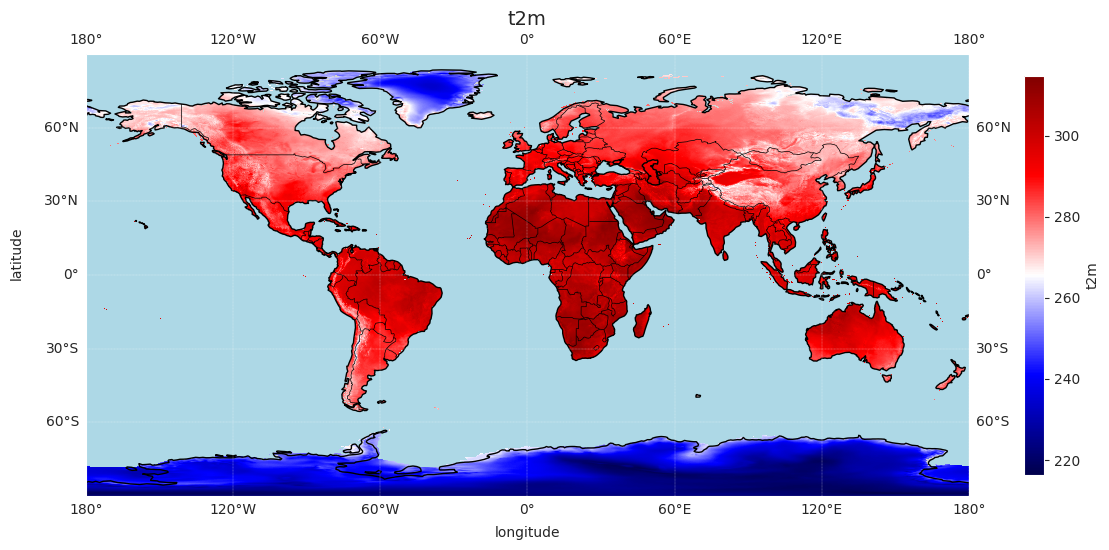

<GeoAxes: title={'center': 't2m'}>

In [2]:
xr_dset = xr.open_dataset("era5-land.nc")
dset = xr_dset.cm.to_signed_longitude()
dset.plot()

## Uniform Sampling (`sample_uniform`)
data are randomly (uniformly) sampled from the entire spatial domain

### Sampling by specifying a portion

Number of points in the sampled dataset: 6483


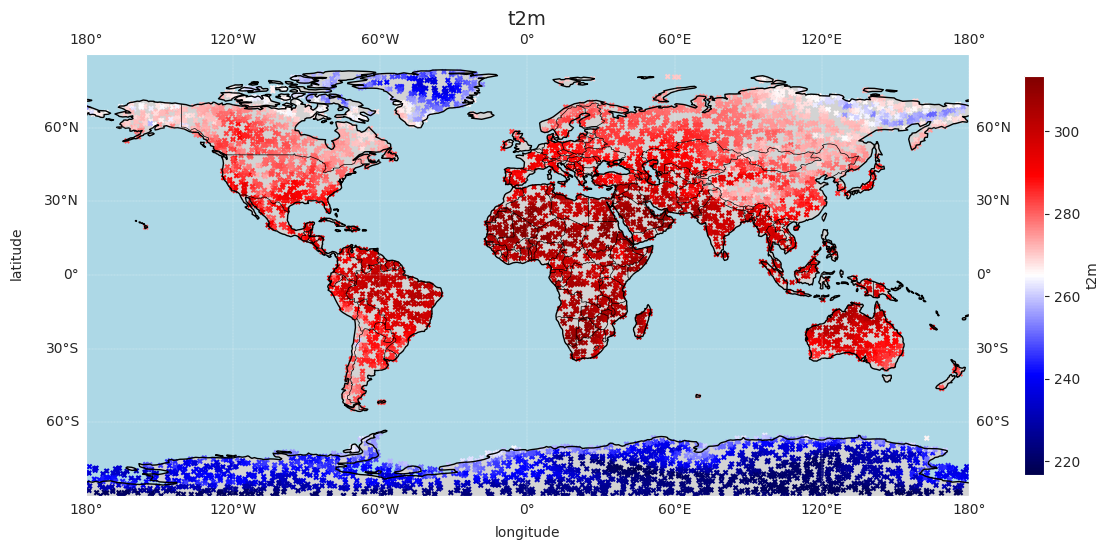

<GeoAxes: title={'center': 't2m'}>

In [3]:
cm_sampled_uniform_portion = dset.sample_uniform(portion=0.001, nan="resample")  # 0.1% of the data
print(f"Number of points in the sampled dataset: {cm_sampled_uniform_portion.domain.size}")
cm_sampled_uniform_portion.plot()

### Sampling by specifying a number of points

Number of points: 15000


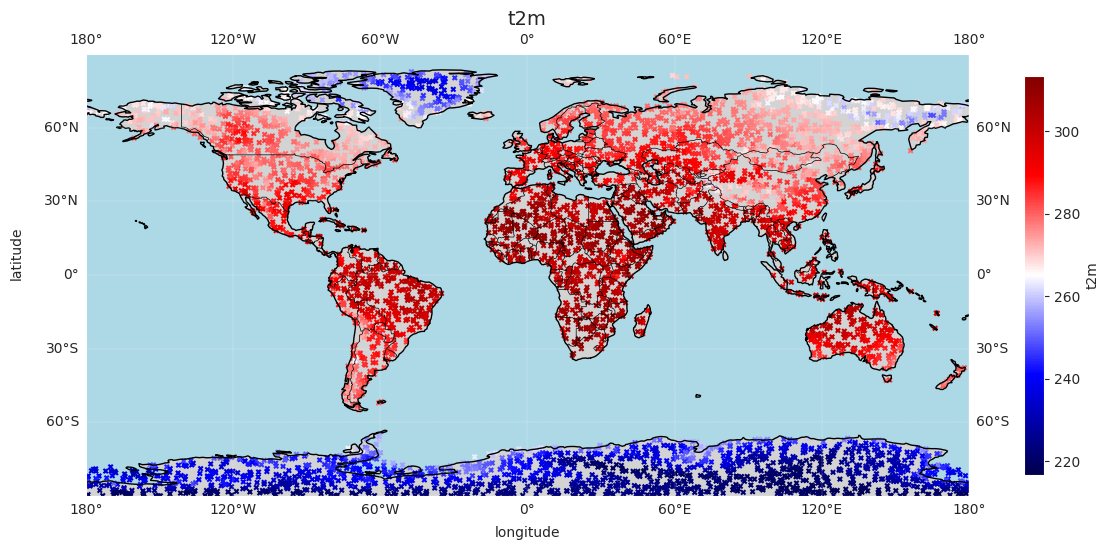

<GeoAxes: title={'center': 't2m'}>

In [4]:
cm_sampled_uniform_number = dset.sample_uniform(number=15_000, nan="ignore")  # 15,000 points
print(f"Number of points: {cm_sampled_uniform_number.domain.size}")
cm_sampled_uniform_number.plot()

## Normal Sampling (`sample_normal`)
data are randomly (following normal distribution) sampled around the defined center point (location).

Number of points: 2000


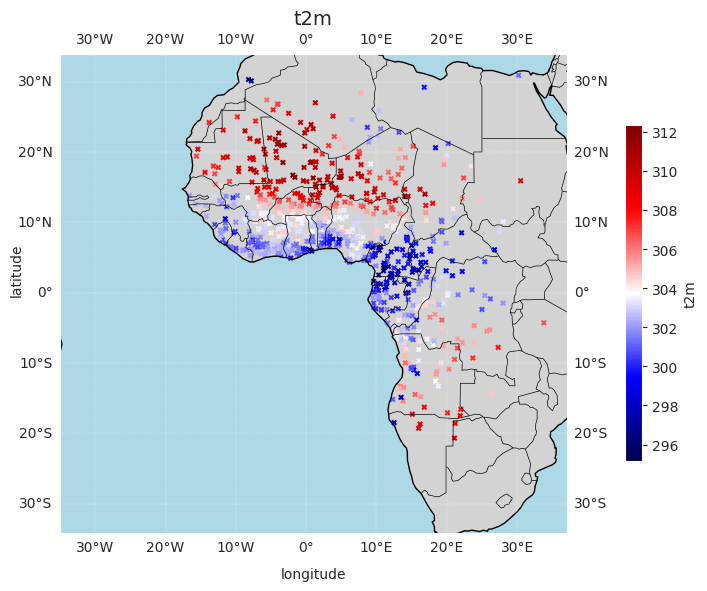

<GeoAxes: title={'center': 't2m'}>

In [5]:
cm_sampled_normal = dset.sample_normal(
    number=2000,
    nan="resample"
)
print(f"Number of points: {cm_sampled_normal.domain.size}")
cm_sampled_normal.plot()


## Handling NaN Values During Sampling
Sampling methods include a `nan` parameter to control behavior when encountering NaN values.
Available strategies (`SamplingNaNPolicy`):
- `IGNORE`: Ignores NaNs (default); the sample may contain NaN values.
- `RESAMPLE`: If a sampled point contains NaN, it resamples.
- `RAISE`: Raises a `ValueError` if any sampled point contains a NaN.

In [6]:
data_with_nans = np.random.rand(1, 91, 181)
data_with_nans[0:20, 0:30] = np.nan

xarray_da = xr.DataArray(
    data=data_with_nans,
    dims=("time", "latitude", "longitude"),
    coords={
        "time": np.array(
            [
                datetime(2000, 1, 1),
            ],
            dtype="datetime64",
        ),
        "latitude": (
            ("latitude",),
            np.arange(-90, 92, 2, dtype=np.float32),
        ),
        "longitude": (
            ("longitude",),
            np.arange(-180, 182, 2, dtype=np.float32),
        ),
    },
)
cm_nans = xarray_da.to_dataset(name="temperature").cm

print(f"Dataset size: {cm_nans.domain.size}")
print(f"Number of NaNs in the original dataset: {np.isnan(cm_nans.da.values).sum()}")

# IGNORE strategy
sampled_ignore_nan = cm_nans.sample_uniform(number=10000, nan=SamplingNaNPolicy.IGNORE)
print(f"\nSampling with IGNORE: number of NaNs in the sample = {np.isnan(sampled_ignore_nan.da.values).sum()}")

# RESAMPLE strategy
sampled_resample_nan = cm_nans.sample_uniform(number=10000, nan=SamplingNaNPolicy.RESAMPLE)
print(f"Sampling with RESAMPLE: number of NaNs in the sample = {np.isnan(sampled_resample_nan.da.values).sum()}")

# RAISE strategy
try:
    cm_nans.sample_uniform(number=12000, nan=SamplingNaNPolicy.RAISE)
except ValueError as error:
    print(f"Expected error caught for RAISE: {error}")

Dataset size: 16471
Number of NaNs in the original dataset: 5430

Sampling with IGNORE: number of NaNs in the sample = 3324
Sampling with RESAMPLE: number of NaNs in the sample = 0
Expected error caught for RAISE: Not all points have data
